In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
import scanpy as sc
import copy
import sys
import glob
from copy import deepcopy
from scipy import stats
from matplotlib.gridspec import GridSpec
import tqdm 
import seaborn as sns
%matplotlib inline

PROJ_DIR = "/home/icb/olle.holmberg/projects/LODE"

sys.path.insert(0, os.path.join(PROJ_DIR, 'feature_segmentation/utils'))

import plotting
plt.style.use('seaborn')

WORK_SPACE = "/storage/groups/ml01/workspace/olle.holmberg/LODE/feature_segmentation"
DATA_DIR = "/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler"

oct_meta_pd = pd.read_csv(os.path.join(DATA_DIR, "joint_export/oct_meta_information.csv"))

oct_meta_pd.loc[:, "sequence"] = oct_meta_pd.PATNR.astype(str) + "_" + oct_meta_pd.laterality

data_pd = pd.read_csv( os.path.join(DATA_DIR, "sequence_data/longitudinal_properties_naive.csv"))

#### add patient id and lateraliy
data_pd["patient_id"] = data_pd.sequence.str.split("_", expand=True)[0]
data_pd["laterality"] = data_pd.sequence.str.split("_", expand=True)[1]

# add seg numpy a
data_pd["seg_record_1"] = data_pd.sequence + "_" + data_pd.study_date_1.str.replace("-", "") + ".npy"
data_pd["seg_record_3"] = data_pd.sequence + "_" + data_pd.study_date_3.str.replace("-", "") + ".npy"
data_pd["seg_record_12"] = data_pd.sequence + "_" + data_pd.study_date_12.str.replace("-", "") + ".npy"


# rename atrophy and thickness columns
for column in data_pd.columns:
    if "atropy_percentage" in column:
        data_pd.rename(columns={column: column.replace("atropy_percentage", "atropypercentage")}, inplace=True)
        
    if "thickness_mean" in column:
        data_pd.rename(columns={column: column.replace("thickness_mean", "thicknessmean")}, inplace=True)

In [2]:
study_date_1_dc = data_pd.sequence.str.split("_", expand=True)
study_date_1_dc = study_date_1_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_1_dc["study_date"] = data_pd["study_date_1"].str.replace("-", "")

study_date_1_dc.PATNR = study_date_1_dc.PATNR.astype(np.int64)
study_date_1_dc.study_date = study_date_1_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result1 = pd.merge(study_date_1_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result1 = result1.drop_duplicates(subset=keys)
result1 = result1.rename(columns={"oct_path": "study_date_1_dicom_path"})

result1["sequence"] = result1.PATNR.astype(str) + "_" + result1.laterality
##############

study_date_3_dc = data_pd.sequence.str.split("_", expand=True)
study_date_3_dc = study_date_3_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_3_dc["study_date"] = data_pd["study_date_3"].str.replace("-", "")

study_date_3_dc.PATNR = study_date_3_dc.PATNR.astype(np.int64)
study_date_3_dc.study_date = study_date_3_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result3 = pd.merge(study_date_3_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result3 = result3.drop_duplicates(subset=keys)
result3 = result3.rename(columns={"oct_path": "study_date_3_dicom_path"})

result3["sequence"] = result3.PATNR.astype(str) + "_" + result3.laterality
#############

study_date_12_dc = data_pd.sequence.str.split("_", expand=True)
study_date_12_dc = study_date_12_dc.rename(columns={0:"PATNR",1:"laterality"})
study_date_12_dc["study_date"] = data_pd["study_date_12"].str.replace("-", "")

study_date_12_dc.PATNR = study_date_12_dc.PATNR.astype(np.int64)
study_date_12_dc.study_date = study_date_12_dc.study_date.astype(np.int64)

keys = ["PATNR", "laterality", "study_date"]
result12 = pd.merge(study_date_12_dc, oct_meta_pd[keys + ["oct_path"]], left_on=keys, right_on=keys, how="left")
result12 = result12.drop_duplicates(subset=keys)
result12 = result12.rename(columns={"oct_path": "study_date_12_dicom_path"})

result12["sequence"] = result12.PATNR.astype(str) + "_" + result12.laterality

data_pd = pd.merge(data_pd, result1[["study_date_1_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

data_pd = pd.merge(data_pd, result3[["study_date_3_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

data_pd = pd.merge(data_pd, result12[["study_date_12_dicom_path", "sequence"]], left_on="sequence", right_on="sequence", 
         how = "left")

In [3]:
columns = ["time_range_3", "time_range_before_3", "time_range_after_3", "insertion_type_3",
            "time_range_6", "time_range_before_6", "time_range_after_6", "insertion_type_6", 
           "time_range_12", "time_range_before_12", "time_range_after_12", "insertion_type_12"]

filter_base = data_pd[columns]

# filter for fist month where VA values are available
filter_1 = ~data_pd.cur_va_rounded_1.isna()

# 3 month bools
interp_3 = filter_base.insertion_type_3 == "interpolation" 
carry_over_3 = filter_base.insertion_type_3 == "carry_over" 
match_3 = filter_base.insertion_type_3 == "match" 

# 6 month bools
interp_6 = filter_base.insertion_type_6 == "interpolation" 
carry_over_6 = filter_base.insertion_type_6 == "carry_over" 
match_6 = filter_base.insertion_type_6 == "match" 

# 12 month bools
interp_12 = filter_base.insertion_type_12 == "interpolation" 
carry_over_12 = filter_base.insertion_type_12 == "carry_over" 
match_12 = filter_base.insertion_type_12 == "match"

DAY_FILTER = 60

# interpolation time filters
interp_time_before_3 = filter_base.time_range_before_3 < DAY_FILTER
interp_time_after_3 = filter_base.time_range_after_3 < DAY_FILTER

interp_time_before_6 = filter_base.time_range_before_6 < DAY_FILTER
interp_time_after_6 = filter_base.time_range_after_6 < DAY_FILTER

interp_time_before_12 = filter_base.time_range_before_12 < DAY_FILTER
interp_time_after_12 = filter_base.time_range_after_12 < DAY_FILTER

# carry over time filters
carry_over_time_after_3 = filter_base.time_range_3 < DAY_FILTER
carry_over_time_after_6 = filter_base.time_range_6 < DAY_FILTER
carry_over_time_after_12 = filter_base.time_range_12 < DAY_FILTER


# interpolation 3 months
interp_bef = np.logical_and(interp_3.values, interp_time_before_3)
interp_aft = np.logical_and(interp_3.values, interp_time_after_3)

interp_3 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_3 = np.logical_and(carry_over_3.values, carry_over_time_after_3)

insertion_3_ = np.logical_or(carry_over_3, interp_3)
filter_3 = np.logical_or(insertion_3_, match_3)

print("Number of filtered sequences for 3 months are:", sum(filter_3))


# interpolation 6 months
interp_bef = np.logical_and(interp_6.values, interp_time_before_6)
interp_aft = np.logical_and(interp_6.values, interp_time_after_6)

interp_6 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_6 = np.logical_and(carry_over_6.values, carry_over_time_after_6)

insertion_6_ = np.logical_or(carry_over_6, interp_6)
filter_6 = np.logical_or(insertion_6_, match_6)

print("Number of filtered sequences for 6 months are:", sum(filter_6))


# interpolation 12 months
interp_bef = np.logical_and(interp_12.values, interp_time_before_12)
interp_aft = np.logical_and(interp_12.values, interp_time_after_12)

interp_12 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_12 = np.logical_and(carry_over_12.values, carry_over_time_after_12)

insertion_12_ = np.logical_or(carry_over_12, interp_12)
filter_12 = np.logical_or(insertion_12_, match_12)

print("Number of filtered sequences for 12 months are:", sum(filter_12))

Number of filtered sequences for 3 months are: 346
Number of filtered sequences for 6 months are: 332
Number of filtered sequences for 12 months are: 278


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

PIXEL_TO_VOLUME = 0.010661*0.003872*0.112878
THICKNESS_TO_MM = 0.003872

def sum_etdrs(table, time):
    label_mapping = {f"_1_{time}":f"epm_{time}", f"_3_{time}":f"irf_{time}", f"_4_{time}":f"srf_{time}", 
                     f"_5_{time}":f"srhm_{time}", f"_6_{time}":f"rpe_{time}", f"_7_{time}":f"fvpde_{time}", 
                     f"_8_{time}":f"drusen_{time}", f"_9_{time}":f"phm_{time}", f"_10_{time}":f"choroid_{time}", 
                     f"_13_{time}":f"fibrosis_{time}", f"_atropypercentage_{time}": f"atropypercentage_{time}",
                     f"_thicknessmean_{time}":f"thicknessmean_{time}"}
    
    feature_names = [f"_1_{time}", f"_3_{time}", 
                     f"_4_{time}", f"_5_{time}", 
                     f"_6_{time}", f"_7_{time}", 
                     f"_8_{time}", f"_9_{time}", 
                     f"_10_{time}", f"_13_{time}",
                     f"_atropypercentage_{time}",
                     f"thicknessmean_{time}"]


    table_non_spatial_pd = pd.DataFrame([])

    for feature in feature_names:
        col_to_sum = table.columns.str.endswith(feature)
        if ("atropy" in feature) | ("thicknessmean" in feature):
            table_non_spatial_pd[feature] = table.iloc[:,col_to_sum].sum(1)*THICKNESS_TO_MM
        else:
            table_non_spatial_pd[feature] = table.iloc[:,col_to_sum].sum(1)*PIXEL_TO_VOLUME

    table_non_spatial_pd = table_non_spatial_pd.rename(columns=label_mapping)
    return table_non_spatial_pd

def add_etdrs(table, time):
    table_spatial_pd = pd.DataFrame([])

    label_mapping = {f"_1_{time}":f"epm_{time}", f"_3_{time}":f"irf_{time}", f"_4_{time}":f"srf_{time}", 
                     f"_5_{time}":f"srhm_{time}", f"_6_{time}":f"rpe_{time}", f"_7_{time}":f"fvpde_{time}", 
                     f"_8_{time}":f"drusen_{time}", f"_9_{time}":f"phm_{time}", f"_10_{time}":f"choroid_{time}", 
                     f"_13_{time}":f"fibrosis_{time}", f"_atropypercentage_{time}": f"atropypercentage_{time}",
                     f"_thicknessmean_{time}":f"thicknessmean_{time}"}


    etdrs_cells = ["T1", "T2", "S1", "S2", "N1", "N2", "I1", "I2", "C0"]

    spatial_label_mapping = {}
    for ecell in etdrs_cells:
        for label_map in label_mapping.keys():
            spatial_label_mapping[f"{ecell}{label_map}"] = f"{ecell}-{label_mapping[label_map]}"

    feature_names = [f"_1_{time}", f"_3_{time}", 
                     f"_4_{time}", f"_5_{time}", 
                     f"_6_{time}", f"_7_{time}", 
                     f"_8_{time}", f"_9_{time}", 
                     f"_10_{time}", f"_13_{time}",
                     f"_atropypercentage_{time}",
                     f"_thicknessmean_{time}"]

    for ecell in etdrs_cells:
        for feature in feature_names:
            spatial_feature = f"{ecell}{feature}"
            
            if spatial_feature in table.columns.tolist():
                if ("atropy" in spatial_feature) | ("thicknessmean" in spatial_feature):
                    table_spatial_pd.loc[:, spatial_feature] = table.loc[:,spatial_feature]*THICKNESS_TO_MM
                else:
                    table_spatial_pd.loc[:, spatial_feature] = table.loc[:,spatial_feature]*PIXEL_TO_VOLUME
    table_spatial_pd = table_spatial_pd.rename(columns=spatial_label_mapping)
    return table_spatial_pd


def calc_delta_columns(times, feature_dict):
    delta_feature_dict = {}
    
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = []
                for col in feature_dict[f"feature_{time}"].columns:
                    feat, t = col.split("_")
                    delta_columns.append(f"{feat}_{next_time_point}_delta_{t}")
                    
                delta_pd = pd.DataFrame(np.array(feature_dict[f"feature_{next_time_point}"]) - 
                                        np.array(feature_dict[f"feature_{time}"]),
                                        columns=delta_columns)

                delta_feature_dict[f"feature_{next_time_point}_{time}"] = delta_pd
    return delta_feature_dict

def get_feature_dicts(times, table, spatial_sum=False):
    feature_dict = {}
    
    for time in times:
        if spatial_sum:   
            feature_dict[f"feature_{time}"] = sum_etdrs(table, time=time)
        else:
            feature_dict[f"feature_{time}"] = add_etdrs(table, time=time)
    
    delta_feature_dict = calc_delta_columns(times, feature_dict)
    return {**delta_feature_dict, **feature_dict}

def get_va_dict(times, table):
    column_starter = "cur_va_rounded_"
    va_dict = {}
    delta_va_dict = {}
    
    for time in times:
        va_dict[f"va_{time}"] = table[f"cur_va_rounded_{time}"]
        
    # calculate delta columns
    for k, time in enumerate(times):
        if k < len(times) - 1:
            remaining_tps = times[k + 1:]
            for next_time_point in remaining_tps:
                delta_columns = [f"va_{next_time_point}_delta_{time}"]
                
                delta_pd = pd.DataFrame(np.array(va_dict[f"va_{next_time_point}"]) - np.array(va_dict[f"va_{time}"]),
                                       columns=delta_columns)
                delta_va_dict[f"va_{next_time_point}_{time}"] = delta_pd
    
    return {**delta_va_dict, **va_dict}


time_filters = {1: filter_1, 3: filter_3, 6: filter_6, 12: filter_12}

def associate_time_n_factors(table=None, spatial_sum=False, times=[1, 12]):
    # filter time points
    for tp in times:
        table = table[time_filters[tp]]
    
    seq_columns = ['patient_id', 'laterality']
    table["sequence"] = table[seq_columns[0]] + "_" + table[seq_columns[1]]
    
    # sum etdrs features for seg features across the time points    
    features_data_dict = get_feature_dicts(times, table, spatial_sum)
    va_data_dict = get_va_dict(times, table)
    
    data_dict = {**va_data_dict, **features_data_dict} 
    data_frames = list(data_dict.keys())

    df = data_dict[data_frames[0]]
    for data_frame in data_frames[1:]:
        df = pd.concat([df.reset_index(drop=True), data_dict[data_frame].reset_index(drop=True)], axis=1)
    
    for time in times[1:]:
        df[f"n_injections_{time}"] = table[f"cumsum_injections_{time}"].values.tolist()
    # filter all columns for the independent ones in list
    df.index = table["sequence"]
    return df

def assert_times(time_point_list):
    allowed_values = [1, 3, 6, 12]
    
    for value in time_point_list:
        if value not in allowed_values:
            return False
        else:
            continue
    return True

# features independents
def get_seg_independents_str(seg_features, seg_delta, seg_times):
    seg_dependents = []
    
    for seg_feature in seg_features:
        for time in seg_times:
            seg_dependents.append(f"{seg_feature}_{time}") 
    
        if seg_delta:
            # add all delta columns
            for k, s_time in enumerate(seg_times[:-1]):

                remaining_times = deepcopy(seg_times)
                remaining_times.remove(s_time)

                for r_time in remaining_times[k:]:
                    if f"{r_time}-{s_time}" in seg_delta:
                        seg_dependents.append(f"{seg_feature}_{r_time}_delta_{s_time}")

    return seg_dependents

def get_va_dependents_str(va_delta, va_times):
    va_dependents = []

    for va_time in va_times:
        va_dependents.append(f"cur_va_rounded_{va_time}")
    
    if va_delta:
        # add all delta columns
        for k, s_time in enumerate(va_times[:-1]):

            remaining_times = deepcopy(va_times)
            remaining_times.remove(s_time)

            for r_time in remaining_times[k:]:
                if f"{r_time}-{s_time}" in va_delta:
                    va_dependents.append(f"va_{r_time}_delta_{s_time}")
                else:
                    continue
    return va_dependents

In [5]:
## Create data visualizations

In [6]:
seg_features = ["epm", "irf", "srf", "srhm", "rpe", "fvpde", "drusen", "phm", "choroid", "fibrosis", 
               "atropypercentage", "thicknessmean"]

seg_delta = []
seg_times = [1, 3, 12]

assert assert_times(seg_times), "Selected time points contains not allowed values"

seg_independents = get_seg_independents_str(seg_features, seg_delta, seg_times)

va_delta = []
va_times = [1, 3, 12]

assert assert_times(va_times), "Selected time points contains not allowed values"

va_independents = get_va_dependents_str(va_delta, va_times)

injection_times = [3]

assert assert_times(injection_times), "Selected time points contains not allowed values"

injection_independents = []
for it in injection_times:
    injection_independents.append(f"n_injections_{it}")

abt = associate_time_n_factors(table=data_pd, spatial_sum=True, times=[1, 3, 12])
abt_spatial = associate_time_n_factors(table=data_pd, spatial_sum=False, times=[1, 3, 12])

seg_indeps = []
for segtime in seg_times:
    seg_indeps.extend(abt.loc[:, ~abt.columns.str.contains("15")].columns.values.tolist())
        
# filter out va columns
# seg_indeps = [i for i in seg_indeps if "va" not in i]
#seg_indeps = [i for i in seg_indeps if "injections" not in i]
seg_indeps = [i for i in seg_indeps if "delta" not in i]


independent_variables = injection_independents + seg_indeps + ["cur_va_rounded_1"]

abt_viz = abt[independent_variables]

# drop duplicate columns
abt_viz = abt_viz.loc[:,~abt_viz.columns.duplicated()]

# add all first order interactions
columns = copy.copy(abt_viz.columns)
            
indep_vars_interactions = list(abt_viz.columns)

abt_viz["va_change"] = abt.cur_va_rounded_12 - abt.cur_va_rounded_1

## join in cataract information

In [7]:
cols_to_merge = ['cataract_surgery_before_sequence', 'cataract_surgery_3',
       'cataract_surgery_6', 'cataract_surgery_12', 'cataract_surgery_24', "sequence"]

abt_viz = pd.merge(abt_viz, data_pd[cols_to_merge], left_on="sequence", right_on="sequence", how="left") 

In [8]:
print("number of eyes with cataract before", data_pd.cataract_surgery_before_sequence.sum())
print("number of eyes with cataract 3", data_pd.cataract_surgery_3.sum())
print("number of eyes with cataract 6", data_pd.cataract_surgery_6.sum())
print("number of eyes with cataract 12", data_pd.cataract_surgery_12.sum())
print("number of eyes with cataract 24", data_pd.cataract_surgery_24.sum())

number of eyes with cataract before 215.0
number of eyes with cataract 3 64.0
number of eyes with cataract 6 2.0
number of eyes with cataract 12 15.0
number of eyes with cataract 24 20.0


In [9]:
print("number of eyes with cataract before", abt_viz.cataract_surgery_before_sequence.sum())
print("number of eyes with cataract 3", abt_viz.cataract_surgery_3.sum())
print("number of eyes with cataract 6", abt_viz.cataract_surgery_6.sum())
print("number of eyes with cataract 12", abt_viz.cataract_surgery_12.sum())

number of eyes with cataract before 67.0
number of eyes with cataract 3 25.0
number of eyes with cataract 6 0.0
number of eyes with cataract 12 4.0


# merge in age and gender information

In [10]:
oct_meta_pd_sub = oct_meta_pd[oct_meta_pd.sequence.isin(list(abt_viz.index))].drop_duplicates(subset=["sequence"])

In [11]:
abt_viz = pd.merge(abt_viz, oct_meta_pd_sub[["sequence", "gender", "age"]].drop_duplicates(), 
                   on="sequence", how="left",)

## get base statistics

In [12]:
abt_viz.columns.values

array(['sequence', 'n_injections_3', 'cur_va_rounded_1',
       'cur_va_rounded_3', 'cur_va_rounded_12', 'epm_1', 'irf_1', 'srf_1',
       'srhm_1', 'rpe_1', 'fvpde_1', 'drusen_1', 'phm_1', 'choroid_1',
       'fibrosis_1', 'atropypercentage_1', 'thicknessmean_1', 'epm_3',
       'irf_3', 'srf_3', 'srhm_3', 'rpe_3', 'fvpde_3', 'drusen_3',
       'phm_3', 'choroid_3', 'fibrosis_3', 'atropypercentage_3',
       'thicknessmean_3', 'epm_12', 'irf_12', 'srf_12', 'srhm_12',
       'rpe_12', 'fvpde_12', 'drusen_12', 'phm_12', 'choroid_12',
       'fibrosis_12', 'atropypercentage_12', 'thicknessmean_12',
       'n_injections_12', 'va_change', 'cataract_surgery_before_sequence',
       'cataract_surgery_3', 'cataract_surgery_6', 'cataract_surgery_12',
       'cataract_surgery_24', 'gender', 'age'], dtype=object)

In [13]:
print("Mean age: ", np.mean(abt_viz.age), np.std(abt_viz.age))
print("sex distribution: ", np.unique(abt_viz.gender, return_counts=1))
print("injection month 3: ", np.mean(abt_viz.n_injections_3), np.std(abt_viz.n_injections_3))
print("injections month 12: ", np.mean(abt_viz.n_injections_12), np.std(abt_viz.n_injections_12))


Mean age:  nan nan
sex distribution:  (array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan

In [14]:
def get_time_dict(feature, time_point, data_pd, feature_change, spatial_sum=True):
    data_temp = associate_time_n_factors(table=data_pd, spatial_sum=spatial_sum, times=[1, time_point])
    
    # calc feature delta
    feature_delta = data_temp[f"{feature}_{time_point}"] - data_temp[f"{feature}_{1}"]
    
    # get data points for feature increase or decrease cases
    if feature_change == "increase":
        data_temp = data_temp[feature_delta >= 0]
    else:
        data_temp = data_temp[feature_delta < 0]
        
    feature_columns = data_temp[[f"{feature}_{time_point}"]]
    feature_columns.loc[:, "va_change"] = data_temp[f"cur_va_rounded_{time_point}"] - data_temp["cur_va_rounded_1"]

    feature_columns["va_class"] = None
    feature_columns["va_class"][feature_columns.va_change > 0.15] = 0
    feature_columns["va_class"][(feature_columns.va_change > -0.15) & (feature_columns.va_change <= 0.15)] = 1
    feature_columns["va_class"][feature_columns.va_change <= -0.15] = 2
    
    n_injections = np.round(data_temp[f"n_injections_{time_point}"].mean(),2)
    
    dict_ = dict(feature_columns.va_class.value_counts())
    dict_[f"injections"] = n_injections
    return dict_

def plot_stacked_bar(viz_dict, time, x_pos):
    
    lost = np.array([viz_dict[time][0]])
    no_change = np.array([viz_dict[time][1]])
    gained = np.array([viz_dict[time][2]])

    # memo of sample number
    snum = lost+no_change+gained

    # normalization
    y1 = lost/snum*100.
    y2 = no_change/snum*100.
    y3 = gained/snum*100.
    
    width = 0.2
    
    # stack bars
    plt.bar(x_pos, y1, color="tab:red", width=width)
    plt.bar(x_pos, y2 , bottom=y1, color="tab:blue", width=width)
    plt.bar(x_pos, y3 , bottom=y1+y2, color="tab:green", width=width)

    # add text annotation corresponding to the percentage of each data.
    for xpos, ypos, yval in zip([x_pos], y1/2, y1):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    for xpos, ypos, yval in zip([x_pos], y1+y2/2, y2):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    for xpos, ypos, yval in zip([x_pos], y1+y2+y3/2, y3):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    
    # add text annotation corresponding to the "total" value of each bar
    for xpos, ypos, yval in zip([x_pos], y1+y2+y3, snum):
        plt.text(xpos, ypos, "N=%d"%yval, ha="center", va="bottom")
        plt.text(xpos, ypos + 4, "mean_inj=%d"%viz_dict[time]["injections"], ha="center", va="bottom")

    plt.ylim(0,110)

## Plot 1 Feature distribution

In [15]:
## add special features
abt_viz = pd.merge(abt_viz, abt_spatial[["C0-choroid_1", 
                                         "C0-choroid_3", 
                                         "C0-choroid_12", 
                                         "C0-thicknessmean_1",
                                         "C0-thicknessmean_3", 
                                         "C0-thicknessmean_12"]], on="sequence")

cataract_f = abt_viz[~abt_viz.cataract_surgery_12.fillna(0).astype(bool)]

In [16]:
feature_list = ["C0-thicknessmean", "C0-choroid", "irf", "rpe", "srf", "srhm", "rpe", "fvpde", "fibrosis", "drusen"]

time_feature_list = []
time_points = [1, 3, 12]
for time in time_points:
    for feature in feature_list:
        time_feature_list.append(f"{feature}_{time}")
        
plot1_ = [i for i in cataract_f.columns.tolist() if i in time_feature_list]

plot1_abt = cataract_f[plot1_ + ["cataract_surgery_before_sequence"]]

plot1_abt.loc[:, "cataract_surgery_before_sequence"] = plot1_abt.cataract_surgery_before_sequence.fillna(0.0)

In [17]:
## check examples
feature = "thicknessmean"
sequence = "15425_R"
seq_pd = cataract_f[cataract_f.sequence == sequence]
feature_cols = ["sequence"] + [col for col in seq_pd.columns.tolist() if feature in col]

seq_pd[feature_cols]

,sequence,thicknessmean_1,thicknessmean_3,thicknessmean_12,C0-thicknessmean_1,C0-thicknessmean_3,C0-thicknessmean_12
16,15425_R,2.864702,3.359947,4.156451,0.199164,0.231573,0.296391


In [18]:
plot1_abt.columns.values

array(['irf_1', 'srf_1', 'srhm_1', 'rpe_1', 'fvpde_1', 'drusen_1',
       'fibrosis_1', 'irf_3', 'srf_3', 'srhm_3', 'rpe_3', 'fvpde_3',
       'drusen_3', 'fibrosis_3', 'irf_12', 'srf_12', 'srhm_12', 'rpe_12',
       'fvpde_12', 'drusen_12', 'fibrosis_12', 'C0-choroid_1',
       'C0-choroid_3', 'C0-choroid_12', 'C0-thicknessmean_1',
       'C0-thicknessmean_3', 'C0-thicknessmean_12',
       'cataract_surgery_before_sequence'], dtype=object)

## print statistics data

In [47]:
plot1_abt.loc[:, "C0-thicknessmean_1"] = plot1_abt.loc[:, "C0-thicknessmean_1"] * 1000
plot1_abt.loc[:, "C0-thicknessmean_3"] = plot1_abt.loc[:, "C0-thicknessmean_3"] * 1000
plot1_abt.loc[:, "C0-thicknessmean_12"] = plot1_abt.loc[:, "C0-thicknessmean_12"] * 1000

In [48]:
seg_features = ["irf", "srf", "srhm", "fvpde", "drusen", "fibrosis",  "C0-thicknessmean"]
seg_times = [1, 3, 12]

stats_log = {}

for feature in seg_features:
    stats_log[feature] = {}
    for time in seg_times:
        if feature == "C0-thicknessmean":
            stats_log[feature][f"mean_{time}"] = plot1_abt.loc[:, f"{feature}_{time}"].mean()
            stats_log[feature][f"std_{time}"] = plot1_abt.loc[:, f"{feature}_{time}"].std()
        else:
            stats_log[feature][f"mean_{time}"] = plot1_abt.loc[:, f"{feature}_{time}"].mean()
            stats_log[feature][f"std_{time}"] = plot1_abt.loc[:, f"{feature}_{time}"].std()

## test for stat significance

In [57]:
pd.DataFrame(stats_log)
from scipy import stats

for feature in seg_features:
    stats_log[feature] = {}
    rvs1 = plot1_abt.loc[:, f"{feature}_{1}"]
    rvs3 = plot1_abt.loc[:, f"{feature}_{3}"]
    rvs12 = plot1_abt.loc[:, f"{feature}_{12}"]
    
    stats_log[feature]["1-3"] = stats.ttest_ind(rvs1, rvs3).pvalue
    stats_log[feature]["1-12"] = stats.ttest_ind(rvs1, rvs12).pvalue
    stats_log[feature]["3-12"] = stats.ttest_ind(rvs3, rvs12).pvalue

pd.DataFrame(stats_log)

,irf,srf,srhm,fvpde,drusen,fibrosis,C0-thicknessmean
1-3,0.000110,1.956845e-11,2.122125e-07,0.051461,0.506801,0.349043,2.133066e-15
1-12,0.000008,2.077576e-09,1.770007e-08,0.059840,0.725886,0.747518,2.966166e-15
3-12,0.697024,9.721103e-02,1.981387e-01,0.863719,0.280216,0.194930,6.842935e-01


Text(0.5, 0.98, 'OCT bio marker change under antiVEGF treatment')

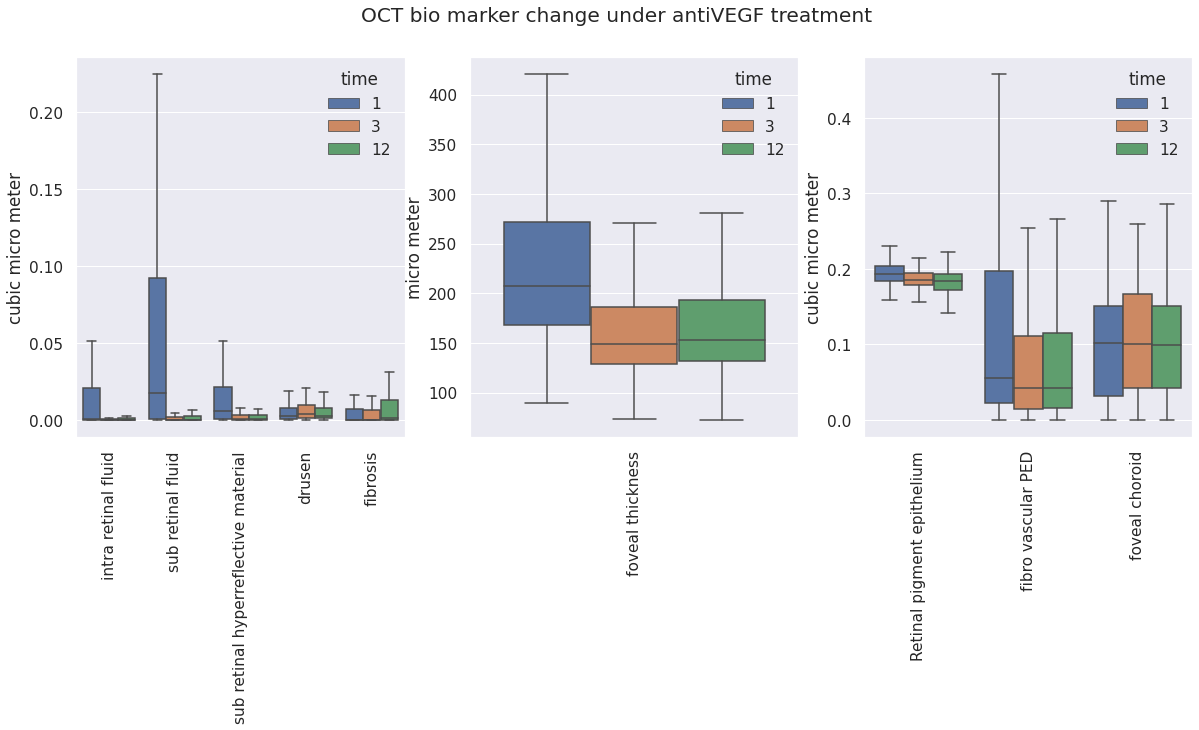

In [50]:
sns.set(font_scale=1.4)
plot1_abt_long = plot1_abt.melt(id_vars=["cataract_surgery_before_sequence"])

plot1_abt_long.loc[:, "time"] = plot1_abt_long.variable.str.split("_", expand=True)[1]
plot1_abt_long.loc[:, "feature"] = plot1_abt_long.variable.str.split("_", expand=True)[0]

small_ = plot1_abt_long.feature.isin(["irf", "srf", "srhm", "drusen", "fibrosis"])
large_ = plot1_abt_long.feature.isin(["fvpde", "rpe", "C0-choroid"])
thickness_ = plot1_abt_long.feature.isin(["C0-thicknessmean"])

cataract_surgery = plot1_abt_long.cataract_surgery_before_sequence == 1.0

plot1_abt_long = plot1_abt_long.rename(columns={"value":"cubim mm"})

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

g0 = sns.boxplot(x="feature", y="cubim mm", hue="time",
            data=plot1_abt_long[small_], 
            showfliers=False, ax=axes[0]);

g0.set(xticks=[0,1,2,3,4])
g0.set_xticklabels(['intra retinal fluid','sub retinal fluid','sub retinal hyperreflective material',
                    'drusen','fibrosis'], rotation=90)

axes[0].set_ylabel("cubic micro meter")


g1 = sns.boxplot(x="feature", y="cubim mm", hue="time",
            data=plot1_abt_long[thickness_], 
            showfliers=False, ax=axes[1]);

axes[1].set_ylabel("micro meter")

g1.set(xticks=[0])
g1.set_xticklabels(['foveal thickness'], rotation=90)

g2 = sns.boxplot(x="feature", y="cubim mm",
            hue="time",
            data=plot1_abt_long[large_], 
            showfliers=False, ax=axes[2] );

g2.set(xticks=[0,1,2])
g2.set_xticklabels(['Retinal pigment epithelium','fibro vascular PED','foveal choroid'], rotation=90)

axes[2].set_ylabel("cubic micro meter")

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

plt.suptitle("OCT bio marker change under antiVEGF treatment")

# Plot 2 Time until dry

In [21]:
abt_viz.columns.values

array(['sequence', 'n_injections_3', 'cur_va_rounded_1',
       'cur_va_rounded_3', 'cur_va_rounded_12', 'epm_1', 'irf_1', 'srf_1',
       'srhm_1', 'rpe_1', 'fvpde_1', 'drusen_1', 'phm_1', 'choroid_1',
       'fibrosis_1', 'atropypercentage_1', 'thicknessmean_1', 'epm_3',
       'irf_3', 'srf_3', 'srhm_3', 'rpe_3', 'fvpde_3', 'drusen_3',
       'phm_3', 'choroid_3', 'fibrosis_3', 'atropypercentage_3',
       'thicknessmean_3', 'epm_12', 'irf_12', 'srf_12', 'srhm_12',
       'rpe_12', 'fvpde_12', 'drusen_12', 'phm_12', 'choroid_12',
       'fibrosis_12', 'atropypercentage_12', 'thicknessmean_12',
       'n_injections_12', 'va_change', 'cataract_surgery_before_sequence',
       'cataract_surgery_3', 'cataract_surgery_6', 'cataract_surgery_12',
       'cataract_surgery_24', 'gender', 'age', 'C0-choroid_1',
       'C0-choroid_3', 'C0-choroid_12', 'C0-thicknessmean_1',
       'C0-thicknessmean_3', 'C0-thicknessmean_12'], dtype=object)

In [22]:
abt_viz.irf_1[abt_viz.irf_1<0.003].shape

(116,)

In [25]:
abt_viz

,sequence,n_injections_3,cur_va_rounded_1,cur_va_rounded_3,cur_va_rounded_12,epm_1,irf_1,srf_1,srhm_1,rpe_1,...,cataract_surgery_12,cataract_surgery_24,gender,age,C0-choroid_1,C0-choroid_3,C0-choroid_12,C0-thicknessmean_1,C0-thicknessmean_3,C0-thicknessmean_12
0,502_L,1.607143,0.30,0.321429,0.400000,0.001244,0.000266,0.000154,0.009128,0.201912,...,0.0,0.0,NaN,NaN,0.025255,0.128004,0.000000,0.286726,0.298325,0.330965
1,709_L,3.000000,0.30,0.600000,0.600000,0.046623,0.008564,0.086337,0.022925,0.196917,...,1.0,0.0,NaN,NaN,0.000037,0.000000,0.000000,0.164423,0.101785,0.150276
2,719_R,3.000000,0.30,0.100000,0.300000,0.007120,0.000112,0.000047,0.000457,0.193674,...,0.0,0.0,NaN,NaN,0.047001,0.067428,0.025040,0.133264,0.131739,0.134880
3,1475_L,3.000000,0.60,0.600000,0.600000,0.000979,0.029961,0.000172,0.000182,0.201217,...,NaN,NaN,NaN,NaN,0.072512,0.000000,0.101876,0.180764,0.112745,0.127837
4,2005_L,3.000000,0.40,0.600000,0.200000,0.002749,0.000163,0.021425,0.005577,0.208272,...,NaN,NaN,NaN,NaN,0.000000,0.225885,0.000000,0.205993,0.227335,0.199698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,379842_R,3.000000,0.40,0.300000,0.300000,0.000214,0.000773,0.261470,0.030744,0.230433,...,0.0,0.0,NaN,NaN,0.135336,0.097161,0.074650,0.452308,0.478238,0.333754
202,380400_R,3.000000,0.30,0.400000,0.240476,0.093904,0.030501,0.008392,0.003360,0.205402,...,0.0,0.0,NaN,NaN,0.145172,0.009874,0.160441,0.279302,0.185612,0.192859
203,381618_L,3.000000,0.89,0.490000,1.000000,0.003579,0.000028,0.021056,0.011160,0.195687,...,NaN,NaN,NaN,NaN,0.164663,0.069134,0.028689,0.243159,0.147593,0.126175
204,383182_L,2.964286,1.20,1.000000,1.000000,0.075713,0.010936,0.000126,0.007367,0.160721,...,0.0,0.0,NaN,NaN,0.140182,0.155868,0.129223,0.142776,0.128729,0.122623


In [26]:
fluid_1 = abt_viz[["irf_1", "srf_1"]].sum(1)
fluid_3 = abt_viz[["irf_3", "srf_3"]].sum(1)
fluid_12 = abt_viz[["irf_12", "srf_12"]].sum(1)

print(f"Number of dry eyes a time point 1: {sum(fluid_1 == 0)}")
print(f"Number of dry eyes a time point 3: {sum(fluid_3 == 0)}")
print(f"Number of dry eyes a time point 12: {sum(fluid_12== 0) }")

Number of dry eyes a time point 1: 3
Number of dry eyes a time point 3: 15
Number of dry eyes a time point 12: 13


Text(0.5, 1.0, 'distribution of thicknessmean among eyes with increased, decreased \n and unchanged visual acuity')

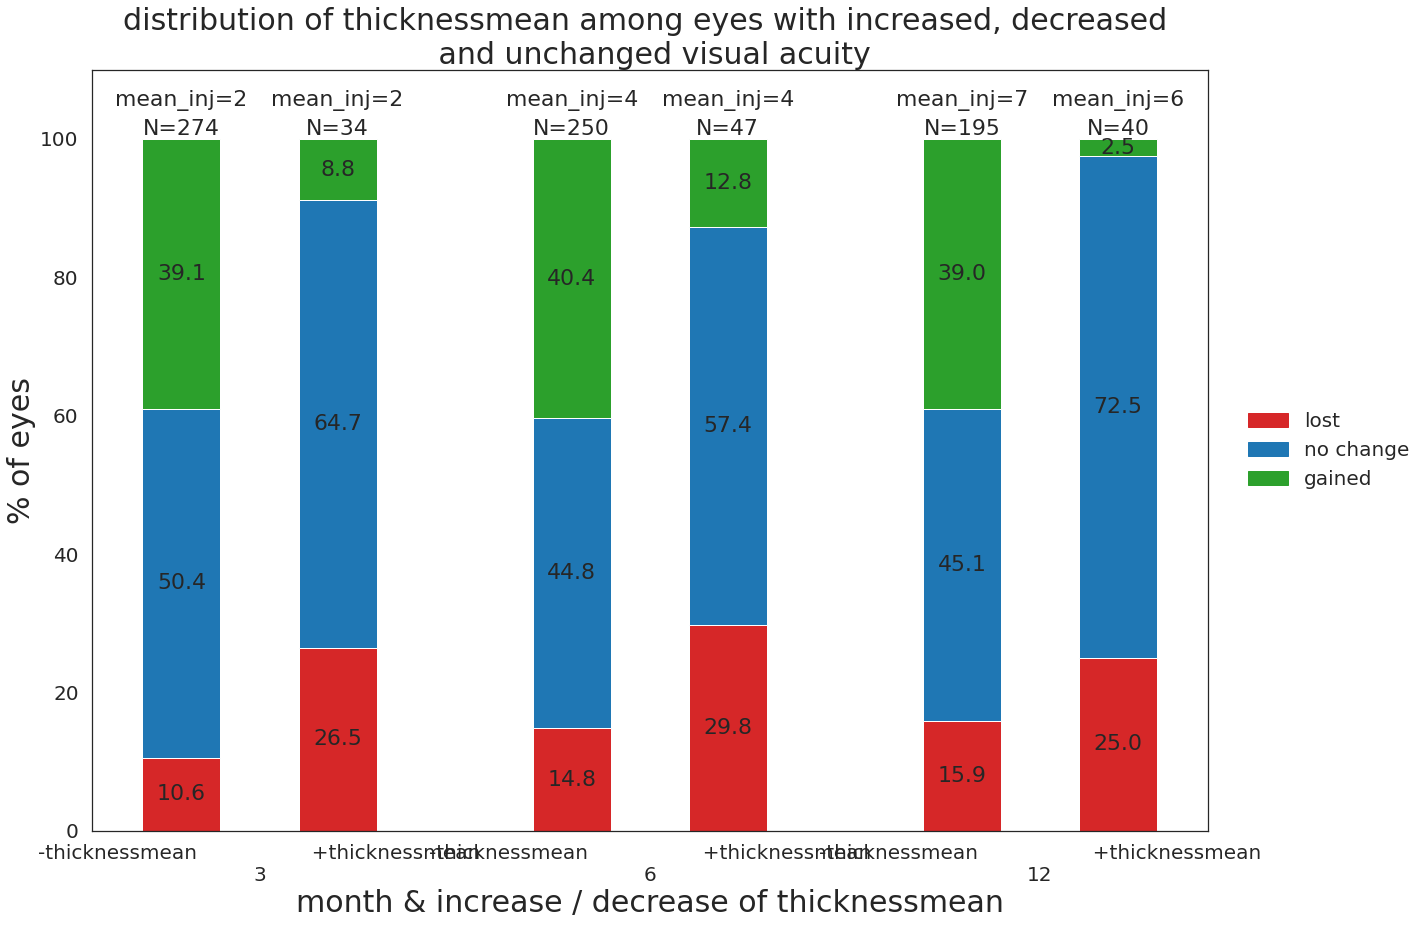

In [27]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib

sns.set_style("white")

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

feature = "thicknessmean"
spatial_sum = True

cataract_bool = (data_pd.cataract_surgery_3 > 0) | (data_pd.cataract_surgery_6 > 0) | \
(data_pd.cataract_surgery_12 > 0)

data_f_pd = data_pd[~cataract_bool]

viz_dict_increased = {}
viz_dict_increased["3"] = get_time_dict(feature, 3, data_f_pd, feature_change="increase", spatial_sum=spatial_sum)
viz_dict_increased["6"] = get_time_dict(feature, 6, data_f_pd, feature_change="increase", spatial_sum=spatial_sum)
viz_dict_increased["12"] = get_time_dict(feature, 12, data_f_pd, feature_change="increase", spatial_sum=spatial_sum)

viz_dict_decreased = {}
viz_dict_decreased["3"] = get_time_dict(feature, 3, data_f_pd, feature_change="decrease", spatial_sum=spatial_sum)
viz_dict_decreased["6"] = get_time_dict(feature, 6, data_f_pd, feature_change="decrease", spatial_sum=spatial_sum)
viz_dict_decreased["12"] = get_time_dict(feature, 12, data_f_pd, feature_change="decrease", spatial_sum=spatial_sum)


plt.figure(figsize=(20,14))

plot_stacked_bar(viz_dict_decreased, time="3", x_pos=1 - 0.2)
plot_stacked_bar(viz_dict_decreased, time="6", x_pos=2 - 0.2)
plot_stacked_bar(viz_dict_decreased, time="12", x_pos=3 - 0.2)

plot_stacked_bar(viz_dict_increased, time="3", x_pos=1 + 0.2)
plot_stacked_bar(viz_dict_increased, time="6", x_pos=2 + 0.2)
plot_stacked_bar(viz_dict_increased, time="12", x_pos=3 + 0.2)

red_patch = mpatches.Patch(color='tab:red', label='lost')
blue_patch = mpatches.Patch(color='tab:blue', label='no change')
green_patch = mpatches.Patch(color='tab:green', label='gained')

plt.legend(handles=[red_patch, blue_patch, green_patch], bbox_to_anchor=(1.02,0.5), loc='center left',
          prop={'size': 20})

space = "                  "
plt.xticks([1,2,3], labels=[f"-{feature}{space}+{feature}\n3", 
                            f"-{feature}{space}+{feature}\n6", 
                            f"-{feature}{space}+{feature}\n12"])

plt.ylabel("% of eyes", size=30)
plt.xlabel(f"month & increase / decrease of {feature}", size=30)
plt.title(f"distribution of {feature} among eyes with increased, decreased \n and unchanged visual acuity",
         size=30)